In [15]:
import scipy
import numpy as np
import networkx as nx
import ot
import time
import multiprocessing as mp
from tqdm import tqdm, trange
import torch
import cvxpy as cp
import torch.nn as nn
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

In [16]:
a = torch.tensor([[0, 1, 1], [1, 2, 1]], dtype=torch.float32)
torch.linalg.norm(a, dim=1, ord=1)

tensor([2., 4.])

In [17]:
import h5py

filename = '/data/sam/modelnet/data/modelnet40_ply_hdf5_2048/ply_data_train1.h5'
dataset = None
labels = None
with h5py.File(filename,'r') as h5f: 
    dataset = h5f['data'][:]
    labels = h5f['label'][:]
    
dataset = dataset - np.expand_dims(np.mean(dataset, axis=0), 0)  # center
dist = np.max(np.sqrt(np.sum(dataset ** 2, axis=1)), 0)
dataset = dataset / dist  # scale

In [18]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=uint8)

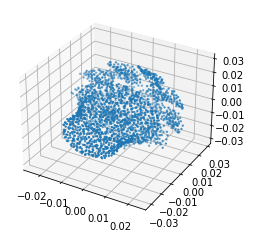

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset[208][:, 0], dataset[208][:, 1], dataset[208][:, 2], s=2)

In [20]:
class PointNetLearner(nn.Module):
    def __init__(self, h_in, h_out, g_out, final_h_layers = 2, num_h_layers=10, num_g_layers=10, final_mlp = False, activation='relu', aggregation='sum'):
        super(PointNetLearner, self).__init__()
        # initial Siamese embedding part
        self.h_out = h_out
        self.g_out = g_out
        self.h = []
        self.h.append(nn.Linear(h_in, h_out))
        for i in range(num_h_layers - 1):
            self.h.append(nn.Linear(h_out, h_out))
        self.h = nn.ModuleList(self.h)
        
        # final MLP
        self.gamma = []
        self.gamma.append(nn.Linear(h_out, g_out))
        for i in range(num_g_layers - 2):
            self.gamma.append(nn.Linear(g_out, g_out))
        self.gamma.append(nn.Linear(g_out, 1))
        self.gamma = nn.ModuleList(self.gamma)

        self.finalMLP = final_mlp
        if activation =='relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise Exception("Activation function not implemented")
        
        layers = []
        for i in range(final_h_layers):
            layers.append(nn.Linear(h_out, h_out))
            layers.append(nn.ReLU())
        self.final_h = nn.Sequential(*layers)
        self.aggregation = aggregation

    
    def get_embedding(self, P):
        out = P
        for layer in self.h:
            out = self.activation(layer(out))
        out = self.final_h(torch.sum(out, axis=0))
        return out 
    
    def get_full_result(self, P, Q):
        P_embd = P
        Q_embd = Q
        for layer in self.h:
            P_embd = self.activation(layer(P_embd))
            Q_embd = self.activation(layer(Q_embd))
        P_embd = torch.sum(P_embd, axis=0)
        Q_embd = torch.sum(Q_embd, axis=0)
        result = P_embd + Q_embd
        for layer in self.gamma:
            result = self.activation(layer(result))
        return result
    
    def reset_parameters(self):
        for layer in self.h:
            torch.nn.init.normal_(layer.weight)
        for layer in self.gamma:
            torch.nn.init.normal_(layer.weight)
        return
    
    def forward(self, Pblock , Qblock, Pidx, Qidx, dists):
        P_embd = Pblock
        Q_embd = Qblock
        for layer in self.h:
            P_embd = self.activation(layer(P_embd))
            Q_embd = self.activation(layer(Q_embd))
            final_embeddings_P = []
            final_embeddings_Q = []
        for i in range(len(Pidx)):
            P_start = Pidx[i][0]
            P_end = Pidx[i][1]

            Q_start = Qidx[i][0]
            Q_end = Qidx[i][1]
            outputP = torch.sum(P_embd[P_start:P_end], axis=0)
            outputQ = torch.sum(Q_embd[Q_start:Q_end], axis=0)
            final_embeddings_P.append(self.final_h(outputP))

            final_embeddings_Q.append(self.final_h(outputQ))
        final_embeddings_P = torch.vstack(final_embeddings_P)
        final_embeddings_Q = torch.vstack(final_embeddings_Q)

        if self.finalMLP:
            if self.aggregation == 'max':
                result = torch.maximum(final_embeddings_P, final_embeddings_Q)
            else:
                result = final_embeddings_P + final_embeddings_Q
            for layer in self.gamma:
                result = self.activation(layer(result))
            
            return torch.mean(torch.square((result-dists)/dists))
        
        #return final_embeddings_P, final_embeddings_Q
        d_pred = torch.sum(torch.abs(final_embeddings_P - final_embeddings_Q), dim=1)
        return torch.mean(torch.abs((d_pred - dists)/dists))


In [21]:
class PointNetDataloader:
    def __init__(self, Ps, Qs, dists, batch_size, shuffle=False):
        self.Ps = Ps
        self.Qs = Qs
        self.total = len(Ps)
        self.dists = torch.tensor(dists)
        self.shuffle = shuffle
        self.batch_size = batch_size

        # Output tensors for each element
        self.Pblock = torch.cat(self.Ps)
        self.Qblock = torch.cat(self.Qs)
        self.Pidx = []
        pstart = 0
        self.Qidx = []
        qstart = 0
        for i in range(self.total):
            psz = len(self.Ps[i])
            qsz = len(self.Qs[i])
            pend = pstart + psz
            qend = qstart + qsz
            self.Pidx.append([pstart, pend])
            self.Qidx.append([qstart, qend])
            pstart = pend
            qstart = qend
        self.Pidx = torch.tensor(self.Pidx)
        self.Qidx = torch.tensor(self.Qidx)
        self.current_batch = 0
    
    def __iter__(self):
        return self

    def __next__(self):
        batch_index = self.current_batch * self.batch_size
        if batch_index >= self.total:
            self.current_batch = 0
            raise StopIteration
        Pidx = self.Pidx[batch_index : batch_index + self.batch_size]
        pblock_start = Pidx[0][0]
        pblock_end = Pidx[-1][1]
        Pblock = self.Pblock[pblock_start:pblock_end]

        Qidx = self.Qidx[batch_index:batch_index + self.batch_size]
        qblock_start = Qidx[0][0]
        qblock_end = Qidx[-1][1]
        Qblock = self.Qblock[qblock_start:qblock_end]
        
        self.current_batch += 1
        return Pblock, Qblock, Pidx, Qidx, self.dists[batch_index:batch_index + self.batch_size]
    
     

In [22]:
# Get ModelNet data
Ps = []
Qs = []
dists = []
mean = np.zeros(3)
cov = np.eye(3)
for i in trange(600):
    P = np.random.multivariate_normal(mean, cov, size=10)
    Q = np.random.multivariate_normal(mean, cov, size=10)
    mat = ot.dist(P, Q, metric='euclidean')
    p = (1/len(P)) * np.ones(len(P))
    q = (1/len(Q)) * np.ones(len(Q))

    dist = ot.emd2(p, q, mat)
    Ps.append(torch.tensor(P, dtype=torch.float32))
    Qs.append( torch.tensor(Q, dtype=torch.float32))
    dists.append(dist)
    

# nmin = 10
# nmax = 100
# szs = []
# print(dataset.shape)
# all_point_sets = []
# ref_point_cloud = dataset[2047]
# for i in trange(10):
#     sz = np.random.randint(low=10, high=100)
#     pcd = ref_point_cloud[np.random.randint(low=0, high=2048, size=sz)]
#     all_point_sets.append(pcd)
    
# for i in trange(10):
#     for j in range(i+1, 10):
#         P = all_point_sets[i]
#         Q = all_point_sets[j]
#         mat = ot.dist(P, Q, metric='euclidean')
#         p = (1/len(P)) * np.ones(len(P))
#         q = (1/len(Q)) * np.ones(len(Q))
        
#         dist = ot.emd2(p, q, mat)
#         Ps.append(torch.tensor(P, dtype=torch.float32))
#         Qs.append( torch.tensor(Q, dtype=torch.float32))
#         dists.append(dist)
    

100%|██████████| 600/600 [00:00<00:00, 2753.21it/s]


In [23]:
# load_data = np.load('/data/sam/modelnet/data/train-datasets/pairs-20.npz', allow_pickle=True)
# Ps = load_data['P']
# Ps = Ps[:10].tolist()
# Qs = load_data['Q']
# Qs = Qs[:10].tolist()
# dists = load_data['dists'][:10]
dataloader = PointNetDataloader(Ps, Qs, dists, batch_size = 32)

In [ ]:
device='cuda:1'
start = 0
layers = 5
h_output_dims = [50, 100, 150, 200]
final_h_layers = [20]
models = []
for j in range(len(final_h_layers)):
    final_h_layer = final_h_layers[j]
    for i in range(len(h_output_dims)):
        h_output_dim = h_output_dims[i]
        model = PointNetLearner(3, h_output_dim, 10, num_h_layers=layers, 
                                num_g_layers=10, final_h_layers=final_h_layer, activation='sigmoid')
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        losses = []
        for i in trange(100):
            optimizer.zero_grad()
            counter = 0
            total_loss = 0
            for data in dataloader:
                counter += 1
                Pblock = data[0].to(device)
                Qblock = data[1].to(device)
                Pidx = data[2].to(device)
                Qidx = data[3].to(device)
                d = data[4].to(device)
                loss = model(Pblock, Qblock, Pidx, Qidx, d)
        #         d_pred = torch.sum(torch.abs(p_embedding - q_embedding), dim=1)
        #         loss = torch.mean(torch.abs((d_pred - d)/d))
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
                total_loss += loss.cpu().detach().numpy()

            # Loss is average of (l_1 distance between vectors - truth)^2 i.e. relative mean squared error
            losses.append(total_loss)

        name = "Width:" + str(h_output_dim) + ", Depth:" + str(layers)
        plt.plot(np.arange(start, len(losses)), losses[start:], label=name)
        plt.legend()
        print(losses[-1])
        models.append(model)
        
    # y = model(P, Q)
    # loss = torch.square(y - dist)
    # loss.backward()
    # optimizer.step()
    # print(loss)
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

19.0


  0%|          | 0/100 [00:00<?, ?it/s]

19.0


  0%|          | 0/100 [00:00<?, ?it/s]

19.0


  8%|▊         | 8/100 [00:38<07:09,  4.67s/it]

In [27]:
# Get ModelNet data
Ps_test = []
Qs_test = []
dists_test = []

mean = np.zeros(3)
cov = np.eye(3)
for i in trange(1000):
    P = np.random.multivariate_normal(mean, cov, size=20)
    Q = np.random.multivariate_normal(mean, cov, size=20)
    mat = ot.dist(P, Q, metric='euclidean')
    p = (1/len(P)) * np.ones(len(P))
    q = (1/len(Q)) * np.ones(len(Q))

    dist = ot.emd2(p, q, mat)
    Ps_test.append(torch.tensor(P, dtype=torch.float32))
    Qs_test.append( torch.tensor(Q, dtype=torch.float32))
    dists_test.append(dist)
# nmin = 10
# nmax = 100
# szs = []
# print(dataset.shape)
# all_point_sets_test = []
# ref_point_cloud = dataset[2047]
# for i in trange(5):
#     sz = np.random.randint(low=10, high=100)
#     pcd = ref_point_cloud[np.random.randint(low=0, high=2048, size=sz)]
#     all_point_sets_test.append(pcd)
    
# for i in trange(5):
#     for j in range(i+1, 5):
#         P = all_point_sets[i]
#         Q = all_point_sets[j]
#         mat = ot.dist(P, Q, metric='euclidean')
#         p = (1/len(P)) * np.ones(len(P))
#         q = (1/len(Q)) * np.ones(len(Q))
        
#         dist = ot.emd2(p, q, mat)
#         Ps_test.append(torch.tensor(P, dtype=torch.float32))
#         Qs_test.append( torch.tensor(Q, dtype=torch.float32))
#         dists_test.append(dist)

100%|██████████| 1000/1000 [00:00<00:00, 2339.30it/s]


MEAN: 0.7282511312799229 R: 0.1882430136645806
MEAN: 0.7575372454081016 R: 0.19121936376323934
MEAN: 0.5122580180051631 R: -0.03387886548414315
MEAN: 0.5777808356476073 R: 0.13051281629849845
MEAN: 0.5513106595624794 R: 0.08528136260150539
MEAN: 0.8823078945045274 R: 0.1889577202408165
MEAN: 1.0915025488061387 R: 0.18761793111617572
MEAN: 0.5852302077971823 R: 0.0542728801925069
MEAN: 0.520809993513702 R: 0.051361309470088
MEAN: 1.0111399535154193 R: 0.19117965637899995
MEAN: 0.9926055053368834 R: 0.0014391339231677764
MEAN: 0.9505932103429068 R: 0.12215279956866106
MEAN: 0.5047073552674983 R: -0.014950647986096174
MEAN: 0.5736484951445063 R: -0.15447695566862554
MEAN: 0.9852408857008641 R: -0.028249706917039617
MEAN: 1.0647164496015233 R: -0.010861026509547261


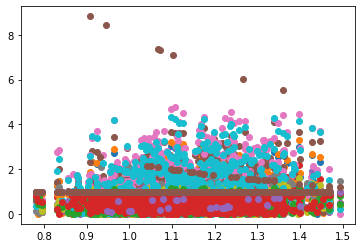

In [29]:
device='cuda:1'
for i in range(len(models)):
    model = models[i]
    results = []
    for i in range(1000):
        P = Ps_test[i].to(device)
        Q = Qs_test[i].to(device)
        dist = dists_test[i]
        pvec = model.get_embedding(P)
        qvec = model.get_embedding(Q)
        res = torch.sum(torch.abs(pvec- qvec)).detach().cpu().numpy()
        results.append(abs(res - dist)/dist)
        #print(torch.sum(torch.abs(pvec- qvec)), dist)
    plt.scatter(dists_test, results)
    r = np.corrcoef(dists_test,results)
    print("MEAN:", np.mean(results), "R:", r[0][1])

    

100%|██████████| 500/500 [03:44<00:00,  2.22it/s]


0.0014992126089055091


100%|██████████| 500/500 [03:28<00:00,  2.40it/s]


0.0014992013748269528


100%|██████████| 500/500 [03:50<00:00,  2.17it/s]

0.0014992151118349284


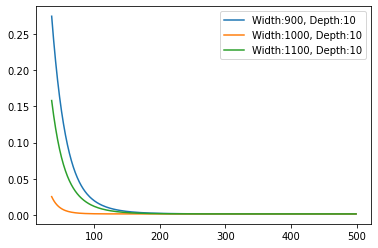

In [26]:
device='cuda:0'
models = []
start = 35
layers = 10
for embedding_size in range(900, 1200, 100):

    model = PointNetLearner(2, embedding_size, 10, num_h_layers=layers, num_g_layers=10, activation='sigmoid', final_mlp=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for i in trange(500):
        optimizer.zero_grad()
        counter = 0
        total_loss = 0
        for data in dataloader:
            counter += 1
            Pblock = data[0].to(device)
            Qblock = data[1].to(device)
            Pidx = data[2].to(device)
            Qidx = data[3].to(device)
            dists = data[4].to(device)
            result = model(Pblock, Qblock, Pidx, Qidx, dists)
            loss = torch.mean(torch.square(dists - result))
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().detach().numpy()
        # Loss is average of (l_1 distance between vectors - truth)^2 i.e. mean squared error
        losses.append(total_loss)
    print(losses[-1])
    
    name = "Width:" + str(embedding_size) + ", Depth:" + str(layers)
    plt.plot(np.arange(start, len(losses)), losses[start:], label=name)
    plt.legend()
    models.append(model)

In [30]:
P_test = []
Q_test = []
dists = []
for i in range(50):
    psz = np.random.randint(low=50, high=100)
    qsz = np.random.randint(low=50, high=100)
    P = np.random.uniform(size=(psz,  2))
    Q = np.random.uniform(size=(qsz, 2))
    mat = ot.dist(P, Q, metric='euclidean')
    p = (1/psz) * np.ones(psz)
    q = (1/qsz) * np.ones(qsz)

    dist = ot.emd2(p, q, mat)

    P_test.append(torch.tensor(P, dtype=torch.float32))
    Q_test.append( torch.tensor(Q, dtype=torch.float32))
    dists.append(dist)
for model in models:
    results = []
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        emd = dists[i]
        pred = model.get_full_result(P, Q).detach().cpu().numpy()
        results.append(abs(emd - pred)/emd)
    print(np.mean(results))
        

0.13330154
0.13330074
0.1333017
